In [ ]:
# pre-demo recommendations
! zenml connect --url https://1cf18d95-zenml.cloudinfra.zenml.io 
! zenml delete model breast_cancer_classifier -y

# Intro to MLOps using ZenML

## 🌍 Overview

This repository is a minimalistic MLOps project intended as a starting point to learn how to put ML workflows in production. It features: 

- A feature engineering pipeline that loads data and prepares it for training.
- A training pipeline that loads the preprocessed dataset and trains a model.
- A batch inference pipeline that runs predictions on the trained model with new data.

Follow along this notebook to understand how you can use ZenML to productionalize your ML workflows!

<img src="_assets/pipeline_overview.png" width="50%" alt="Pipelines Overview">

# 👶 Step 0. Install Requirements

Let's install ZenML to get started. First we'll install the latest version of
ZenML as well as the `sklearn` integration of ZenML:

In [ ]:
!zenml integration install sklearn -y

import IPython
IPython.Application.instance().kernel.do_shutdown(restart=True)

Please wait for the installation to complete before running subsequent cells. At
the end of the installation, the notebook kernel will automatically restart.

Optional: If you are using [ZenML Cloud](https://zenml.io/cloud), execute the following cell with your tenant URL. Otherwise ignore.

In [ ]:
!zenml connect --url https://1cf18d95-zenml.cloudinfra.zenml.io

In [70]:
# Initialize ZenML and set the default stack
!zenml init

!zenml stack set local-sagemaker-step-operator-wandb

The ZenML global configuration version (0.55.2) is higher than the version of ZenML currently being used (0.55.1). Read more about this issue and how to solve it here: https://docs.zenml.io/user-guide/advanced-guide/environment-management/global-settings-of-zenml#version-mismatch-downgrading
Found existing ZenML repository at path 
'/Users/andrei.vishniakov/Documents/GitHub/zenml-projects/stack-showcase'.
⠋ Initializing ZenML repository at 
/Users/andrei.vishniakov/Documents/GitHub/zenml-projects/stack-showcase.
⠋ Initializing ZenML repository at 
/Users/andrei.vishniakov/Documents/GitHub/zenml-projects/stack-showcase.

The ZenML global configuration version (0.55.2) is higher than the version of ZenML currently being used (0.55.1). Read more about this issue and how to solve it here: https://docs.zenml.io/user-guide/advanced-guide/environment-management/global-settings-of-zenml#version-mismatch-downgrading
⠋ Setting the repository active stack to 
Active repository stack set to: 'loca

In [71]:
# Do the imports at the top
from typing_extensions import Annotated
from sklearn.datasets import load_breast_cancer

import pandas as pd
from zenml import step, pipeline, Model, get_step_context
from zenml.client import Client
from zenml.logger import get_logger
from uuid import UUID

from typing import Optional, List

from zenml import pipeline

from steps import (
    data_loader,
    data_preprocessor,
    data_splitter,
    model_evaluator,
    inference_preprocessor
)

from zenml.logger import get_logger

logger = get_logger(__name__)

# Initialize the ZenML client to fetch objects from the ZenML Server
client = Client()

## 🥇 Step 1: Load your data and execute feature engineering

We'll start off by importing our data. In this quickstart we'll be working with
[the Breast Cancer](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) dataset
which is publicly available on the UCI Machine Learning Repository. The task is a classification
problem, to predict whether a patient is diagnosed with breast cancer or not.

When you're getting started with a machine learning problem you'll want to do
something similar to this: import your data and get it in the right shape for
your training. ZenML mostly gets out of your way when you're writing your Python
code, as you'll see from the following cell.

<img src="_assets/feature_engineering_pipeline.png" width="50%" alt="Feature engineering pipeline" />

In [72]:
@step
def data_loader_simplified(
    random_state: int, is_inference: bool = False, target: str = "target"
) -> Annotated[pd.DataFrame, "dataset"]:  # We name the dataset 
    """Dataset reader step."""
    dataset = load_breast_cancer(as_frame=True)
    inference_size = int(len(dataset.target) * 0.05)
    dataset: pd.DataFrame = dataset.frame
    inference_subset = dataset.sample(inference_size, random_state=random_state)
    if is_inference:
        dataset = inference_subset
        dataset.drop(columns=target, inplace=True)
    else:
        dataset.drop(inference_subset.index, inplace=True)
    dataset.reset_index(drop=True, inplace=True)
    logger.info(f"Dataset with {len(dataset)} records loaded!")
    return dataset


The whole function is decorated with the `@step` decorator, which
tells ZenML to track this function as a step in the pipeline. This means that
ZenML will automatically version, track, and cache the data that is produced by
this function as an `artifact`. This is a very powerful feature, as it means that you can
reproduce your data at any point in the future, even if the original data source
changes or disappears. 

Note the use of the `typing` module's `Annotated` type hint in the output of the
step. We're using this to give a name to the output of the step, which will make
it possible to access it via a keyword later on.

You'll also notice that we have included type hints for the outputs
to the function. These are not only useful for anyone reading your code, but
help ZenML process your data in a way appropriate to the specific data types.

ZenML is built in a way that allows you to experiment with your data and build
your pipelines as you work, so if you want to call this function to see how it
works, you can just call it directly. Here we take a look at the first few rows
of your training dataset.

In [73]:
df = data_loader_simplified(random_state=42)
df.head()

Dataset with 541 records loaded!
Dataset with 541 records loaded!
Dataset with 541 records loaded!


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Everything looks as we'd expect and the values are all in the right format 🥳.

We're now at the point where can bring this step (and some others) together into a single
pipeline, the top-level organising entity for code in ZenML. Creating such a pipeline is
as simple as adding a `@pipeline` decorator to a function. This specific
pipeline doesn't return a value, but that option is available to you if you need.

In [91]:
@pipeline
def feature_engineering(
    test_size: float = 0.3,
    drop_na: Optional[bool] = None,
    normalize: Optional[bool] = None,
    drop_columns: Optional[List[str]] = None,
    target: Optional[str] = "target",
    random_state: int = 17
):
    """Feature engineering pipeline."""
    # Link all the steps together by calling them and passing the output
    # of one step as the input of the next step.
    raw_data = data_loader(random_state=random_state, target=target)
    dataset_trn, dataset_tst = data_splitter(
        dataset=raw_data,
        test_size=test_size,
    )
    dataset_trn, dataset_tst, _ = data_preprocessor(
        dataset_trn=dataset_trn,
        dataset_tst=dataset_tst,
        drop_na=drop_na,
        normalize=normalize,
        drop_columns=drop_columns,
        target=target,
        random_state=random_state,
    )

    return dataset_trn, dataset_tst

We're ready to run the pipeline now, which we can do just as with the step - by calling the
pipeline function itself:

In [77]:
feature_engineering(random_state=42)

Initiating a new run for the pipeline: feature_engineering.
Registered new version: (version 32).
Executing a new run.
Using user: andrei@zenml.io
Using stack: local-mlflow-stack
  model_registry: mlflow
  model_deployer: mlflow
  experiment_tracker: mlflow
  artifact_store: default
  orchestrator: default
Step data_loader has started.
Dataset with 541 records loaded!
Step data_loader has finished in 1.014s.
Step data_splitter has started.
Step data_splitter has finished in 1.782s.
Step data_preprocessor has started.
Step data_preprocessor has finished in 2.333s.
Pipeline run has finished in 6.991s.
Dashboard URL: https://1cf18d95-zenml.cloudinfra.zenml.io/workspaces/default/pipelines/4f30b522-a840-4763-ba5f-9bb1f64d7bd5/runs/5da24a7d-26c0-4e21-ad6d-80f83df4c2fe/dag


PipelineRunResponse(id=UUID('5da24a7d-26c0-4e21-ad6d-80f83df4c2fe'), permission_denied=False, body=PipelineRunResponseBody(created=datetime.datetime(2024, 2, 8, 11, 8, 49), updated=datetime.datetime(2024, 2, 8, 11, 8, 49), user=UserResponse(id=UUID('c915043d-706c-4885-9263-783cae8dad20'), permission_denied=False, body=UserResponseBody(created=datetime.datetime(2023, 11, 16, 16, 5, 33), updated=datetime.datetime(2024, 2, 8, 10, 24, 32), active=True, activation_token=None, full_name='Andrei', email_opted_in=True, is_service_account=False), metadata=None, name='andrei@zenml.io'), status=<ExecutionStatus.INITIALIZING: 'initializing'>, stack=StackResponse(id=UUID('57f7dcf2-4bd5-439b-b454-da4000dd3bc8'), permission_denied=False, body=StackResponseBody(created=datetime.datetime(2023, 12, 11, 15, 24, 51), updated=datetime.datetime(2023, 12, 21, 1, 15, 28), user=UserResponse(id=UUID('ac044541-bcb1-4f33-b41e-5c60a3f39485'), permission_denied=False, body=UserResponseBody(created=datetime.datetime

Let's run this again with a slightly different test size, to create more datasets:

In [78]:
feature_engineering(random_state=42,test_size=0.25)

Initiating a new run for the pipeline: feature_engineering.
Registered new version: (version 33).
Executing a new run.
Using user: andrei@zenml.io
Using stack: local-mlflow-stack
  model_registry: mlflow
  model_deployer: mlflow
  experiment_tracker: mlflow
  artifact_store: default
  orchestrator: default
Using cached version of data_loader.
Step data_loader has started.
Step data_splitter has started.
Step data_splitter has finished in 1.760s.
Step data_preprocessor has started.
Step data_preprocessor has finished in 2.609s.
Pipeline run has finished in 6.297s.
Dashboard URL: https://1cf18d95-zenml.cloudinfra.zenml.io/workspaces/default/pipelines/32f8d3ca-b993-4135-86a6-16eef2f254bd/runs/c5f5291c-7a6f-45da-bdb8-d24e64c07688/dag


PipelineRunResponse(id=UUID('c5f5291c-7a6f-45da-bdb8-d24e64c07688'), permission_denied=False, body=PipelineRunResponseBody(created=datetime.datetime(2024, 2, 8, 11, 9, 1), updated=datetime.datetime(2024, 2, 8, 11, 9, 1), user=UserResponse(id=UUID('c915043d-706c-4885-9263-783cae8dad20'), permission_denied=False, body=UserResponseBody(created=datetime.datetime(2023, 11, 16, 16, 5, 33), updated=datetime.datetime(2024, 2, 8, 10, 24, 32), active=True, activation_token=None, full_name='Andrei', email_opted_in=True, is_service_account=False), metadata=None, name='andrei@zenml.io'), status=<ExecutionStatus.INITIALIZING: 'initializing'>, stack=StackResponse(id=UUID('57f7dcf2-4bd5-439b-b454-da4000dd3bc8'), permission_denied=False, body=StackResponseBody(created=datetime.datetime(2023, 12, 11, 15, 24, 51), updated=datetime.datetime(2023, 12, 21, 1, 15, 28), user=UserResponse(id=UUID('ac044541-bcb1-4f33-b41e-5c60a3f39485'), permission_denied=False, body=UserResponseBody(created=datetime.datetime(2

Notice the second time around, the data loader step was **cached**, while the rest of the pipeline was rerun. 
This is because ZenML automatically determined that nothing had changed in the data loader step, 
so it didn't need to rerun it.

Let's run this again with a slightly different test size and random state, to disable the cache and to create more datasets:

In [79]:
feature_engineering(test_size=0.25, random_state=104)

Initiating a new run for the pipeline: feature_engineering.
Registered new version: (version 34).
Executing a new run.
Using user: andrei@zenml.io
Using stack: local-mlflow-stack
  model_registry: mlflow
  model_deployer: mlflow
  experiment_tracker: mlflow
  artifact_store: default
  orchestrator: default
Step data_loader has started.
Dataset with 541 records loaded!
Step data_loader has finished in 1.051s.
Step data_splitter has started.
Step data_splitter has finished in 1.780s.
Step data_preprocessor has started.
Step data_preprocessor has finished in 2.473s.
Pipeline run has finished in 7.075s.
Dashboard URL: https://1cf18d95-zenml.cloudinfra.zenml.io/workspaces/default/pipelines/3678fc6f-919a-4564-a38d-8dea60a425ce/runs/6f8066a8-ca40-4481-96a3-d8ada6e6cf1e/dag


PipelineRunResponse(id=UUID('6f8066a8-ca40-4481-96a3-d8ada6e6cf1e'), permission_denied=False, body=PipelineRunResponseBody(created=datetime.datetime(2024, 2, 8, 11, 9, 17), updated=datetime.datetime(2024, 2, 8, 11, 9, 17), user=UserResponse(id=UUID('c915043d-706c-4885-9263-783cae8dad20'), permission_denied=False, body=UserResponseBody(created=datetime.datetime(2023, 11, 16, 16, 5, 33), updated=datetime.datetime(2024, 2, 8, 10, 24, 32), active=True, activation_token=None, full_name='Andrei', email_opted_in=True, is_service_account=False), metadata=None, name='andrei@zenml.io'), status=<ExecutionStatus.INITIALIZING: 'initializing'>, stack=StackResponse(id=UUID('57f7dcf2-4bd5-439b-b454-da4000dd3bc8'), permission_denied=False, body=StackResponseBody(created=datetime.datetime(2023, 12, 11, 15, 24, 51), updated=datetime.datetime(2023, 12, 21, 1, 15, 28), user=UserResponse(id=UUID('ac044541-bcb1-4f33-b41e-5c60a3f39485'), permission_denied=False, body=UserResponseBody(created=datetime.datetime

We can also fetch the pipeline from the server and view the results directly in the notebook:

In [80]:
client = Client()
run = client.get_pipeline("feature_engineering").last_run
print(run.name)

feature_engineering-2024_02_08-11_09_17_420170


We can also see the data artifacts that were produced by the last step of the pipeline:

In [81]:
run.steps["data_preprocessor"].outputs

{'dataset_trn': ArtifactVersionResponse(id=UUID('5aee13f2-3a73-4f6e-8daa-b41e95c6078a'), permission_denied=False, body=ArtifactVersionResponseBody(created=datetime.datetime(2024, 2, 8, 11, 9, 23), updated=datetime.datetime(2024, 2, 8, 11, 9, 23), user=UserResponse(id=UUID('c915043d-706c-4885-9263-783cae8dad20'), permission_denied=False, body=UserResponseBody(created=datetime.datetime(2023, 11, 16, 16, 5, 33), updated=datetime.datetime(2024, 2, 8, 10, 24, 32), active=True, activation_token=None, full_name='Andrei', email_opted_in=True, is_service_account=False), metadata=None, name='andrei@zenml.io'), artifact=ArtifactResponse(id=UUID('2f71c5a3-333a-4aa0-b5b4-341c26ee7f77'), permission_denied=False, body=ArtifactResponseBody(created=datetime.datetime(2023, 12, 12, 10, 29, 43), updated=datetime.datetime(2023, 12, 12, 10, 29, 43), tags=[]), metadata=None, name='dataset_trn'), version='261', uri='/Users/andrei.vishniakov/Library/Application Support/zenml/local_stores/466b79ce-3df9-4549-a50

In [82]:
# Read one of the datasets. This is the one with a 0.25 test split
run.steps["data_preprocessor"].outputs["dataset_trn"].load()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
444,12.040,28.14,76.85,449.9,0.08752,0.06000,0.023670,0.02377,0.1854,0.05698,...,33.33,87.24,567.6,0.10410,0.09726,0.05524,0.05547,0.2404,0.06639,1
478,9.676,13.14,64.12,272.5,0.12550,0.22040,0.118800,0.07038,0.2057,0.09575,...,18.04,69.47,328.1,0.20060,0.36630,0.29130,0.10750,0.2848,0.13640,1
210,10.440,15.46,66.62,329.6,0.10530,0.07722,0.006643,0.01216,0.1788,0.06450,...,19.80,73.47,395.4,0.13410,0.11530,0.02639,0.04464,0.2615,0.08269,1
299,12.430,17.00,78.60,477.3,0.07557,0.03454,0.013420,0.01699,0.1472,0.05561,...,20.21,81.76,515.9,0.08409,0.04712,0.02237,0.02832,0.1901,0.05932,1
513,14.470,24.99,95.81,656.4,0.08837,0.12300,0.100900,0.03890,0.1872,0.06341,...,31.73,113.50,808.9,0.13400,0.42020,0.40400,0.12050,0.3187,0.10230,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,16.070,19.65,104.10,817.7,0.09168,0.08424,0.097690,0.06638,0.1798,0.05391,...,24.56,128.80,1223.0,0.15000,0.20450,0.28290,0.15200,0.2650,0.06387,0
106,10.510,20.19,68.64,334.2,0.11220,0.13030,0.064760,0.03068,0.1922,0.07782,...,22.75,72.62,374.4,0.13000,0.20490,0.12950,0.06136,0.2383,0.09026,1
270,14.410,19.73,96.03,651.0,0.08757,0.16760,0.136200,0.06602,0.1714,0.07192,...,22.13,101.70,767.3,0.09983,0.24720,0.22200,0.10210,0.2272,0.08799,1
435,27.420,26.27,186.90,2501.0,0.10840,0.19880,0.363500,0.16890,0.2061,0.05623,...,31.37,251.20,4254.0,0.13570,0.42560,0.68330,0.26250,0.2641,0.07427,0


We can also get the artifacts directly. Each time you create a new pipeline run, a new `artifact version` is created.

You can fetch these artifact and their versions using the `client`: 

In [83]:
# Get artifact version from our run
dataset_trn_artifact_version_via_run = run.steps["data_preprocessor"].outputs["dataset_trn"] 

# Get latest version from client directly
dataset_trn_artifact_version = client.get_artifact_version("dataset_trn")

# This should be true if our run is the latest run and no artifact has been produced
#  in the intervening time
dataset_trn_artifact_version_via_run.id == dataset_trn_artifact_version.id

True

In [84]:
# Fetch the rest of the artifacts
dataset_tst_artifact_version = client.get_artifact_version("dataset_tst")
preprocessing_pipeline_artifact_version = client.get_artifact_version("preprocess_pipeline")

If you started with a fresh install, then you would have two versions corresponding
to the two pipelines that we ran above. We can even load a artifact version in memory:   

In [85]:
# Load an artifact to verify you can fetch it
dataset_trn_artifact_version.load()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
444,12.040,28.14,76.85,449.9,0.08752,0.06000,0.023670,0.02377,0.1854,0.05698,...,33.33,87.24,567.6,0.10410,0.09726,0.05524,0.05547,0.2404,0.06639,1
478,9.676,13.14,64.12,272.5,0.12550,0.22040,0.118800,0.07038,0.2057,0.09575,...,18.04,69.47,328.1,0.20060,0.36630,0.29130,0.10750,0.2848,0.13640,1
210,10.440,15.46,66.62,329.6,0.10530,0.07722,0.006643,0.01216,0.1788,0.06450,...,19.80,73.47,395.4,0.13410,0.11530,0.02639,0.04464,0.2615,0.08269,1
299,12.430,17.00,78.60,477.3,0.07557,0.03454,0.013420,0.01699,0.1472,0.05561,...,20.21,81.76,515.9,0.08409,0.04712,0.02237,0.02832,0.1901,0.05932,1
513,14.470,24.99,95.81,656.4,0.08837,0.12300,0.100900,0.03890,0.1872,0.06341,...,31.73,113.50,808.9,0.13400,0.42020,0.40400,0.12050,0.3187,0.10230,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,16.070,19.65,104.10,817.7,0.09168,0.08424,0.097690,0.06638,0.1798,0.05391,...,24.56,128.80,1223.0,0.15000,0.20450,0.28290,0.15200,0.2650,0.06387,0
106,10.510,20.19,68.64,334.2,0.11220,0.13030,0.064760,0.03068,0.1922,0.07782,...,22.75,72.62,374.4,0.13000,0.20490,0.12950,0.06136,0.2383,0.09026,1
270,14.410,19.73,96.03,651.0,0.08757,0.16760,0.136200,0.06602,0.1714,0.07192,...,22.13,101.70,767.3,0.09983,0.24720,0.22200,0.10210,0.2272,0.08799,1
435,27.420,26.27,186.90,2501.0,0.10840,0.19880,0.363500,0.16890,0.2061,0.05623,...,31.37,251.20,4254.0,0.13570,0.42560,0.68330,0.26250,0.2641,0.07427,0


We'll use these artifacts from above in our next pipeline

# ⌚ Step 2: Training pipeline

Now that we have our data it makes sense to train some models to get a sense of
how difficult the task is. The Breast Cancer dataset is sufficiently large and complex 
that it's unlikely we'll be able to train a model that behaves perfectly since the problem 
is inherently complex, but we can get a sense of what a reasonable baseline looks like.

We'll start with two simple models, a SGD Classifier and a Random Forest
Classifier, both batteries-included from `sklearn`. We'll train them both on the
same data and then compare their performance.

<img src="_assets/training_pipeline.png" width="50%" alt="Training pipeline">

In [86]:
import pandas as pd
from sklearn.base import ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from typing_extensions import Annotated
from zenml import ArtifactConfig, step
from zenml.logger import get_logger

logger = get_logger(__name__)


@step
def model_trainer(
    dataset_trn: pd.DataFrame,
    model_type: str = "sgd",
) -> Annotated[
    ClassifierMixin,
    ArtifactConfig(name="sklearn_classifier", is_model_artifact=True),
]:
    """Configure and train a model on the training dataset."""
    target = "target"
    if model_type == "sgd":
        model = SGDClassifier()
    elif model_type == "rf":
        model = RandomForestClassifier()
    else:
        raise ValueError(f"Unknown model type {model_type}")

    logger.info(f"Training model {model}...")

    model.fit(
        dataset_trn.drop(columns=[target]),
        dataset_trn[target],
    )
    return model

Our two training steps both return different kinds of `sklearn` classifier
models, so we use the generic `ClassifierMixin` type hint for the return type.

ZenML allows you to load any version of any dataset that is tracked by the framework
directly into a pipeline using the `Client().get_artifact_version` interface. This is very convenient
in this case, as we'd like to send our preprocessed dataset from the older pipeline directly
into the training pipeline.

In [101]:
from zenml import ExternalArtifact

@pipeline
def training(
    train_dataset_id: Optional[UUID] = None,
    test_dataset_id: Optional[UUID] = None,
    model_type: str = "sgd",
    min_train_accuracy: float = 0.0,
    min_test_accuracy: float = 0.0,
):
    """Model training pipeline.""" 
    if train_dataset_id is None or test_dataset_id is None:
        # If we dont pass the IDs, this will run the feature engineering pipeline   
        dataset_trn, dataset_tst = feature_engineering()
    else:
        # Load the datasets from an older pipeline
        dataset_trn = ExternalArtifact(id=train_dataset_id)
        dataset_tst = ExternalArtifact(id=test_dataset_id)
        # dataset_trn = client.get_artifact_version(name_id_or_prefix=train_dataset_id)
        # dataset_tst = client.get_artifact_version(name_id_or_prefix=test_dataset_id) 

    trained_model = model_trainer(
        dataset_trn=dataset_trn,
        model_type=model_type,
    )

    model_evaluator(
        model=trained_model,
        dataset_trn=dataset_trn,
        dataset_tst=dataset_tst,
        min_train_accuracy=min_train_accuracy,
        min_test_accuracy=min_test_accuracy,
    )

The end goal of this quick baseline evaluation is to understand which of the two
models performs better. We'll use the `evaluator` step to compare the two
models. This step takes in the model from the trainer step, and computes its score
over the testing set.

In [102]:
# Use a random forest model with the chosen datasets.
# We need to pass the ID's of the datasets into the function
training(
    model_type="rf",
    train_dataset_id=dataset_trn_artifact_version.id,
    test_dataset_id=dataset_tst_artifact_version.id
)

rf_run = client.get_pipeline("training").last_run

Initiating a new run for the pipeline: training.
Registered new version: (version 94).
Executing a new run.
Using user: andrei@zenml.io
Using stack: local-mlflow-stack
  model_registry: mlflow
  model_deployer: mlflow
  experiment_tracker: mlflow
  artifact_store: default
  orchestrator: default
Step model_trainer has started.
Training model RandomForestClassifier()...
Training model RandomForestClassifier()...
Training model RandomForestClassifier()...
Training model RandomForestClassifier()...
Step model_trainer has finished in 0.993s.
Step model_evaluator has started.
Train accuracy=100.00%
Test accuracy=90.44%
Step model_evaluator has finished in 1.154s.
Pipeline run has finished in 4.104s.
Dashboard URL: https://1cf18d95-zenml.cloudinfra.zenml.io/workspaces/default/pipelines/d7de5d44-e92c-4da8-b716-3ee8e1851698/runs/a039c329-b39f-44fc-98bc-58510f82c09d/dag


In [103]:
# Use a SGD classifier
sgd_run = training(
    model_type="sgd",
    train_dataset_id=dataset_trn_artifact_version.id,
    test_dataset_id=dataset_tst_artifact_version.id
)

sgd_run = client.get_pipeline("training").last_run

Initiating a new run for the pipeline: training.
Registered new version: (version 95).
Executing a new run.
Using user: andrei@zenml.io
Using stack: local-mlflow-stack
  model_registry: mlflow
  model_deployer: mlflow
  experiment_tracker: mlflow
  artifact_store: default
  orchestrator: default
Step model_trainer has started.
Training model SGDClassifier()...
Training model SGDClassifier()...
Training model SGDClassifier()...
Training model SGDClassifier()...
Step model_trainer has finished in 0.880s.
Step model_evaluator has started.
Train accuracy=91.60%
Test accuracy=90.44%
Step model_evaluator has finished in 1.159s.
Pipeline run has finished in 3.931s.
Dashboard URL: https://1cf18d95-zenml.cloudinfra.zenml.io/workspaces/default/pipelines/9d131977-eb26-44c5-90d6-bb6a5f0b9f43/runs/d3f30c80-3813-498b-ba6f-d5df041cfa8f/dag


You can see from the logs already how our model training went: the
`RandomForestClassifier` performed considerably better than the `SGDClassifier`.
We can use the ZenML `Client` to verify this:

In [105]:
# The evaluator returns a float value with the accuracy
rf_run.steps["model_evaluator"].output.load() >= sgd_run.steps["model_evaluator"].output.load()

True

# 💯 Step 3: Associating a model with your pipeline

You can see it is relatively easy to train ML models using ZenML pipelines. But it can be somewhat clunky to track
all the models produced as you develop your experiments and use-cases. Luckily, ZenML offers a *Model Control Plane*,
which is a central register of all your ML models.

You can easily create a ZenML Model and associate it with your pipelines using the `Model` object:

In [110]:
pipeline_settings = {}

# Lets add some metadata to the model to make it identifiable
pipeline_settings["model"] = Model(
    name="breast_cancer_classifier",
    license="Apache 2.0",
    description="A breast cancer classifier",
)

In [111]:
# Let's train the SGD model and tag the version name with "sgd"
pipeline_settings["model"].tags = ["breast_cancer", "classifier", "sgd"]

# the `with_options` method allows us to pass in pipeline settings
#  and returns a configured pipeline
training_configured = training.with_options(**pipeline_settings)

# We can now run this as usual
training_configured(
    model_type="sgd",
    train_dataset_id=dataset_trn_artifact_version.id,
    test_dataset_id=dataset_tst_artifact_version.id
)

Initiating a new run for the pipeline: training.
Reusing registered pipeline version: (version: 95).
New model breast_cancer_classifier was created implicitly.
New model version 1 was created.
Executing a new run.
Using user: andrei@zenml.io
Using stack: local-mlflow-stack
  model_registry: mlflow
  model_deployer: mlflow
  experiment_tracker: mlflow
  artifact_store: default
  orchestrator: default
Using cached version of model_trainer.
Step model_trainer has started.
Using cached version of model_evaluator.
Step model_evaluator has started.
Pipeline run has finished in 3.267s.
Dashboard URL: https://1cf18d95-zenml.cloudinfra.zenml.io/workspaces/default/pipelines/9d131977-eb26-44c5-90d6-bb6a5f0b9f43/runs/a93c0c85-ef7e-4f11-8726-6b66bebe56d2/dag


PipelineRunResponse(id=UUID('a93c0c85-ef7e-4f11-8726-6b66bebe56d2'), permission_denied=False, body=PipelineRunResponseBody(created=datetime.datetime(2024, 2, 8, 11, 24, 53), updated=datetime.datetime(2024, 2, 8, 11, 24, 53), user=UserResponse(id=UUID('c915043d-706c-4885-9263-783cae8dad20'), permission_denied=False, body=UserResponseBody(created=datetime.datetime(2023, 11, 16, 16, 5, 33), updated=datetime.datetime(2024, 2, 8, 10, 24, 32), active=True, activation_token=None, full_name='Andrei', email_opted_in=True, is_service_account=False), metadata=None, name='andrei@zenml.io'), status=<ExecutionStatus.INITIALIZING: 'initializing'>, stack=StackResponse(id=UUID('57f7dcf2-4bd5-439b-b454-da4000dd3bc8'), permission_denied=False, body=StackResponseBody(created=datetime.datetime(2023, 12, 11, 15, 24, 51), updated=datetime.datetime(2023, 12, 21, 1, 15, 28), user=UserResponse(id=UUID('ac044541-bcb1-4f33-b41e-5c60a3f39485'), permission_denied=False, body=UserResponseBody(created=datetime.dateti

In [112]:
# Let's train the RF model and tag the version name with "rf"
pipeline_settings["model"].tags = ["breast_cancer", "classifier", "rf"]

# the `with_options` method allows us to pass in pipeline settings
#  and returns a configured pipeline
training_configured = training.with_options(**pipeline_settings)

# Let's run it again to make sure we have two versions
training_configured(
    model_type="rf",
    train_dataset_id=dataset_trn_artifact_version.id,
    test_dataset_id=dataset_tst_artifact_version.id
)

Initiating a new run for the pipeline: training.
Reusing registered pipeline version: (version: 94).
Provided model configuration does not match existing model breast_cancer_classifier with the following changes: {'tags added': ['rf'], 'tags removed': ['sgd']}. If you want to update the model configuration, please use the zenml model update command.
New model version 2 was created.
Executing a new run.
Using user: andrei@zenml.io
Using stack: local-mlflow-stack
  model_registry: mlflow
  model_deployer: mlflow
  experiment_tracker: mlflow
  artifact_store: default
  orchestrator: default
Using cached version of model_trainer.
Provided model configuration does not match existing model breast_cancer_classifier with the following changes: {'tags added': ['rf'], 'tags removed': ['sgd']}. If you want to update the model configuration, please use the zenml model update command.
Step model_trainer has started.
Using cached version of model_evaluator.
Provided model configuration does not matc

PipelineRunResponse(id=UUID('4adb298a-d725-4a8b-a79f-fe89b96898d9'), permission_denied=False, body=PipelineRunResponseBody(created=datetime.datetime(2024, 2, 8, 11, 24, 59), updated=datetime.datetime(2024, 2, 8, 11, 24, 59), user=UserResponse(id=UUID('c915043d-706c-4885-9263-783cae8dad20'), permission_denied=False, body=UserResponseBody(created=datetime.datetime(2023, 11, 16, 16, 5, 33), updated=datetime.datetime(2024, 2, 8, 10, 24, 32), active=True, activation_token=None, full_name='Andrei', email_opted_in=True, is_service_account=False), metadata=None, name='andrei@zenml.io'), status=<ExecutionStatus.INITIALIZING: 'initializing'>, stack=StackResponse(id=UUID('57f7dcf2-4bd5-439b-b454-da4000dd3bc8'), permission_denied=False, body=StackResponseBody(created=datetime.datetime(2023, 12, 11, 15, 24, 51), updated=datetime.datetime(2023, 12, 21, 1, 15, 28), user=UserResponse(id=UUID('ac044541-bcb1-4f33-b41e-5c60a3f39485'), permission_denied=False, body=UserResponseBody(created=datetime.dateti

This time, running both pipelines has created two associated **model versions**.
You can list your ZenML model and their versions as follows:

In [113]:
zenml_model = client.get_model("breast_cancer_classifier")
print(zenml_model)

versions = zenml_model.versions

print(f"Model {zenml_model.name} has {len(versions)} versions")

versions[-2].version, versions[-1].version

id=UUID('cb1ac539-bac3-45ca-8837-c6bc0942e4e8') permission_denied=False body=ModelResponseBody(created=datetime.datetime(2024, 2, 8, 11, 24, 51), updated=datetime.datetime(2024, 2, 8, 11, 24, 51), user=UserResponse(id=UUID('c915043d-706c-4885-9263-783cae8dad20'), permission_denied=False, body=UserResponseBody(created=datetime.datetime(2023, 11, 16, 16, 5, 33), updated=datetime.datetime(2024, 2, 8, 10, 24, 32), active=True, activation_token=None, full_name='Andrei', email_opted_in=True, is_service_account=False), metadata=None, name='andrei@zenml.io'), tags=[TagResponse(id=UUID('dad60bad-aeda-42fc-8108-a49e0b451b34'), permission_denied=False, body=TagResponseBody(created=datetime.datetime(2023, 12, 12, 15, 8, 29), updated=datetime.datetime(2023, 12, 12, 15, 8, 29), color=<ColorVariants.PURPLE: 'purple'>, tagged_count=3), metadata=None, name='classifier'), TagResponse(id=UUID('12c4c193-5bc8-4ef7-bedc-0b4e2732bc54'), permission_denied=False, body=TagResponseBody(created=datetime.datetime(

('1', '2')

The interesting part is that ZenML went ahead and linked all artifacts produced by the
pipelines to that model version, including the two pickle files that represent our
SGD and RandomForest classifier. We can see all artifacts directly from the model
version object:

In [114]:
# Let's load the RF version
rf_zenml_model_version = client.list_model_versions("breast_cancer_classifier", tag="rf")[-1]

# We can now load our classifier directly as well
random_forest_classifier = rf_zenml_model_version.get_artifact("sklearn_classifier").load()

random_forest_classifier

RandomForestClassifier()

If you are a [ZenML Cloud](https://zenml.io/cloud) user, you can see all of this visualized in the dashboard:

<img src="_assets/cloud_mcp_screenshot.png" width="70%" alt="Model Control Plane">

There is a lot more you can do with ZenML models, including the ability to
track metrics by adding metadata to it, or having them persist in a model
registry. However, these topics can be explored more in the
[ZenML docs](https://docs.zenml.io).

For now, we will use the ZenML model control plane to promote our best
model to `production`. You can do this by simply setting the `stage` of
your chosen model version to the `production` tag.

In [115]:
# Set our best classifier to production
rf_zenml_model_version.set_stage("production", force=True)

Of course, normally one would only promote the model by comparing to all other model
versions and doing some other tests. But that's a bit more advanced use-case. See the
[e2e_batch example](https://github.com/zenml-io/zenml/tree/main/examples/e2e) to get
more insight into that sort of flow!

<img src="_assets/cloud_mcp.png" width="60%" alt="Model Control Plane">

Once the model is promoted, we can now consume the right model version in our
batch inference pipeline directly. Let's see how that works.

# 🫅 Step 4: Consuming the model in production

The batch inference pipeline simply takes the model marked as `production` and runs inference on it
with `live data`. The critical step here is the `inference_predict` step, where we load the model in memory
and generate predictions:

<img src="_assets/inference_pipeline.png" width="45%" alt="Inference pipeline">

In [116]:
@step
def inference_predict(dataset_inf: pd.DataFrame) -> Annotated[pd.Series, "predictions"]:
    """Predictions step"""
    # Get the model
    model = get_step_context().model

    # run prediction from memory
    predictor = model.load_artifact("sklearn_classifier")
    predictions = predictor.predict(dataset_inf)

    predictions = pd.Series(predictions, name="predicted")

    return predictions


Apart from the loading the model, we must also load the preprocessing pipeline that we ran in feature engineering,
so that we can do the exact steps that we did on training time, in inference time. Let's bring it all together:

In [120]:
@pipeline
def inference(preprocess_pipeline_id: UUID):
    """Model batch inference pipeline"""
    # random_state = client.get_artifact_version(name_id_or_prefix=preprocess_pipeline_id).metadata["random_state"].value
    # target = client.get_artifact_version(name_id_or_prefix=preprocess_pipeline_id).run_metadata['target'].value
    random_state = 42
    target = "target"

    df_inference = data_loader(
        random_state=random_state, is_inference=True
    )
    df_inference = inference_preprocessor(
        dataset_inf=df_inference,
        # We use the preprocess pipeline from the feature engineering pipeline
        preprocess_pipeline=ExternalArtifact(id=preprocess_pipeline_id),
        target=target,
    )
    inference_predict(
        dataset_inf=df_inference,
    )


The way to load the right model is to pass in the `production` stage into the `Model` config this time.
This will ensure to always load the production model, decoupled from all other pipelines:

In [121]:
pipeline_settings = {"enable_cache": False}

# Lets add some metadata to the model to make it identifiable
pipeline_settings["model"] = Model(
    name="breast_cancer_classifier",
    version="production", # We can pass in the stage name here!
)

version production matches one of the possible ModelStages and will be fetched using stage.


In [122]:
# the `with_options` method allows us to pass in pipeline settings
#  and returns a configured pipeline
inference_configured = inference.with_options(**pipeline_settings)

# Let's run it again to make sure we have two versions
# We need to pass in the ID of the preprocessing done in the feature engineering pipeline
# in order to avoid training-serving skew
inference_configured(
    preprocess_pipeline_id=preprocessing_pipeline_artifact_version.id
)

Initiating a new run for the pipeline: inference.


Registered new version: (version 16).
Executing a new run.
Caching is disabled by default for inference.
Using user: andrei@zenml.io
Using stack: local-mlflow-stack
  model_registry: mlflow
  model_deployer: mlflow
  experiment_tracker: mlflow
  artifact_store: default
  orchestrator: default
Step data_loader has started.
Dataset with 28 records loaded!
Step data_loader has finished in 4.069s.
Step inference_preprocessor has started.
Step inference_preprocessor has finished in 4.373s.
Step inference_predict has started.
You specified both an ID as well as a version of the artifact_versions. Ignoring the version and fetching the artifact_versions by ID.
Step inference_predict has finished in 5.387s.
Pipeline run has finished in 15.779s.
Dashboard URL: https://1cf18d95-zenml.cloudinfra.zenml.io/workspaces/default/pipelines/9711266c-1ab0-411e-8ccc-18760cc5aed1/runs/c89eb7d0-e53a-48cc-92fb-ffe2a5287db4/dag


PipelineRunResponse(id=UUID('c89eb7d0-e53a-48cc-92fb-ffe2a5287db4'), permission_denied=False, body=PipelineRunResponseBody(created=datetime.datetime(2024, 2, 8, 11, 27, 40), updated=datetime.datetime(2024, 2, 8, 11, 27, 40), user=UserResponse(id=UUID('c915043d-706c-4885-9263-783cae8dad20'), permission_denied=False, body=UserResponseBody(created=datetime.datetime(2023, 11, 16, 16, 5, 33), updated=datetime.datetime(2024, 2, 8, 10, 24, 32), active=True, activation_token=None, full_name='Andrei', email_opted_in=True, is_service_account=False), metadata=None, name='andrei@zenml.io'), status=<ExecutionStatus.INITIALIZING: 'initializing'>, stack=StackResponse(id=UUID('57f7dcf2-4bd5-439b-b454-da4000dd3bc8'), permission_denied=False, body=StackResponseBody(created=datetime.datetime(2023, 12, 11, 15, 24, 51), updated=datetime.datetime(2023, 12, 21, 1, 15, 28), user=UserResponse(id=UUID('ac044541-bcb1-4f33-b41e-5c60a3f39485'), permission_denied=False, body=UserResponseBody(created=datetime.dateti

ZenML automatically links all artifacts to the `production` model version as well, including the predictions
that were returned in the pipeline. This completes the MLOps loop of training to inference:

In [123]:
# Fetch production model
production_model_version = client.get_model_version("breast_cancer_classifier", "production")

# Get the predictions artifact
production_model_version.get_artifact("predictions").load()

0     1
1     0
2     0
3     1
4     1
5     0
6     0
7     0
8     0
9     1
10    1
11    0
12    1
13    0
14    1
15    0
16    1
17    1
18    1
19    0
20    1
21    1
22    0
23    1
24    1
25    1
26    1
27    1
Name: series, dtype: int64

You can also see all predictions ever created as a complete history in the dashboard:

<img src="_assets/cloud_mcp_predictions.png" width="70%" alt="Model Control Plane">

# 🙏 Step 5: Bringing it all together

Let's run all the moving pieces we navigated in the previous steps using production ready python script `run.py`

In [124]:
!zenml stack set local-wandb
!zenml stack describe local-wandb

The ZenML global configuration version (0.55.2) is higher than the version of ZenML currently being used (0.55.1). Read more about this issue and how to solve it here: https://docs.zenml.io/user-guide/advanced-guide/environment-management/global-settings-of-zenml#version-mismatch-downgrading
Active repository stack set to: 'local-wandb'.
⠋ Setting the repository active stack to 'local-wandb'...b'...
The ZenML global configuration version (0.55.2) is higher than the version of ZenML currently being used (0.55.1). Read more about this issue and how to solve it here: https://docs.zenml.io/user-guide/advanced-guide/environment-management/global-settings-of-zenml#version-mismatch-downgrading
⠋ Describing the stack...
          Stack Configuration          
┏━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━┓
┃ COMPONENT_TYPE     │ COMPONENT_NAME ┃
┠────────────────────┼────────────────┨
┃ ARTIFACT_STORE     │ default        ┃
┠────────────────────┼────────────────┨
┃ EXPERIMENT_TRACKER │ zenml_wandb    

In [126]:
!python3 run.py --training-pipeline --inference-pipeline

The ZenML global configuration version (0.55.2) is higher than the version of ZenML currently being used (0.55.1). Read more about this issue and how to solve it here: https://docs.zenml.io/user-guide/advanced-guide/environment-management/global-settings-of-zenml#version-mismatch-downgrading
Initiating a new run for the pipeline: training.
Registered new version: (version 98).
New model version 5 was created.
Executing a new run.
Using user: andrei@zenml.io
Using stack: local-wandb
  artifact_store: default
  experiment_tracker: zenml_wandb
  orchestrator: default
Step data_loader has started.
Dataset with 541 records loaded!
Step data_loader has finished in 3.972s.
Step data_splitter has started.
Step data_splitter has finished in 5.907s.
Step data_preprocessor has started.
Step data_preprocessor has finished in 7.590s.
Step model_trainer has started.
Training model SGDClassifier()...
Step model_trainer has finished in 3.851s.
Step model_evaluator has started.
Initializing wandb with 

Now full run executed on local stack and experiment is tracked using Model Control Plane and Weights&Biases.

Let's move some heavy lifting steps to the Sagemaker keeping light ones on local, so we can reduce costs. This can be achieved using step operators and step configurations.

To make this happen we will use extended configuration files having following step level settings:
```yaml
steps:
  model_trainer:
    step_operator: sagemaker-eu # instruct to run step on sagemaker
    settings:
      step_operator:
        sagemaker:
          estimator_args: 
            instance_type : ml.m5.large # select instance type
```

<img src="_assets/local_sagmaker_so_stack.png" width="60%" alt="Sagemaker step_op stack">

In [19]:
!zenml stack set local-sagemaker-step-operator-wandb
!zenml stack describe local-sagemaker-step-operator-wandb

The ZenML global configuration version (0.55.2) is higher than the version of ZenML currently being used (0.55.1). Read more about this issue and how to solve it here: https://docs.zenml.io/user-guide/advanced-guide/environment-management/global-settings-of-zenml#version-mismatch-downgrading
⠋ Setting the repository active stack to 
Active repository stack set to: 'local-sagemaker-step-operator-wandb'
⠋ Setting the repository active stack to 
⠋ Setting the repository active stack to 
'local-sagemaker-step-operator-wandb'...
The ZenML global configuration version (0.55.2) is higher than the version of ZenML currently being used (0.55.1). Read more about this issue and how to solve it here: https://docs.zenml.io/user-guide/advanced-guide/environment-management/global-settings-of-zenml#version-mismatch-downgrading
⠋ Describing the stack...
          Stack Configuration          
┏━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━┓
┃ COMPONENT_TYPE     │ COMPONENT_NAME ┃
┠────────────────────┼─────────

In [26]:
!python3 run.py --training-pipeline --inference-pipeline --custom-training-suffix _sagemaker

The ZenML global configuration version (0.55.2) is higher than the version of ZenML currently being used (0.55.1). Read more about this issue and how to solve it here: https://docs.zenml.io/user-guide/advanced-guide/environment-management/global-settings-of-zenml#version-mismatch-downgrading
Initiating a new run for the pipeline: training.
Registered new version: (version 84).
Building Docker image(s) for pipeline training.
Building Docker image 715803424590.dkr.ecr.eu-central-1.amazonaws.com/zenml:training-model_trainer-sagemaker_step_operator.
- Including user-defined requirements: pyarrow
- Including integration requirements: Pillow>=9.1.0, aws-profile-manager, boto3<=1.26.76, kubernetes, s3fs>2022.3.0,<=2023.4.0, sagemaker==2.117.0, scikit-learn, wandb>=0.12.12
Could not import GCP service connector: No module named 'google.api_core'.
Could not import Azure service connector: No module named 'azure.identity'.
Step 1/11 : FROM zenmldocker/zenml:0.55.1-py3.11
Step 2/11 : WORKDIR /app

# 🐙 Step 6: Analyzing results

In [127]:
from zenml.client import Client
client = Client()

In [128]:
sgd_model_version = client.list_model_versions("breast_cancer_classifier",tag="sgd")[-1]
rf_model_version = client.list_model_versions("breast_cancer_classifier",tag="rf")[-1]
print(f"SGD version is staged as `{sgd_model_version.stage}`")
print(f"RF version is staged as `{rf_model_version.stage}`")

SGD version is staged as `None`
RF version is staged as `production`


At first, let's pull some meta information collected during models evaluation stage. To recall we used this step as evaluator:
```python
@step
def model_evaluator(
    model: ClassifierMixin,
    dataset_trn: pd.DataFrame,
    dataset_tst: pd.DataFrame,
    min_train_accuracy: float = 0.0,
    min_test_accuracy: float = 0.0,
    target: Optional[str] = "target",
) -> float:
    # Calculate the model accuracy on the train and test set
    trn_acc = model.score(...)
    tst_acc = model.score(...)

    ...
    
    predictions = model.predict(dataset_tst.drop(columns=[target]))
    metadata = {
        "train_accuracy": float(trn_acc),
        "test_accuracy": float(tst_acc),
        "confusion_matrix": confusion_matrix(dataset_tst[target], predictions)
        .ravel()
        .tolist(),
    }
    log_model_metadata(metadata={"wandb_url": wandb.run.url})
    log_artifact_metadata(
        metadata=metadata,
        artifact_name="sklearn_classifier",
    )

    wandb.log({"train_accuracy": metadata["train_accuracy"]})
    wandb.log({"test_accuracy": metadata["test_accuracy"]})
    wandb.log(
        {
            "confusion_matrix": wandb.sklearn.plot_confusion_matrix(
                dataset_tst[target], predictions, ["No Cancer", "Cancer"]
            )
        }
    )
    return float(tst_acc)
```
First we pull Accuracy metrics out of both model version for comparison:

In [129]:
sgd_clf_metadata = sgd_model_version.get_artifact("sklearn_classifier").run_metadata
rf_clf_metadata = rf_model_version.get_artifact("sklearn_classifier").run_metadata
print(f"SGD{' (production)' if sgd_model_version.stage == 'production' else ''} metrics: train={sgd_clf_metadata['train_accuracy'].value*100:.2f}% test={sgd_clf_metadata['test_accuracy'].value*100:.2f}%")
print(f"RF{' (production)' if rf_model_version.stage == 'production' else ''} metrics: train={rf_clf_metadata['train_accuracy'].value*100:.2f}% test={rf_clf_metadata['test_accuracy'].value*100:.2f}%")

SGD metrics: train=81.02% test=79.82%
RF (production) metrics: train=100.00% test=98.17%


Now lets' plot collected Confusion Matrixes:

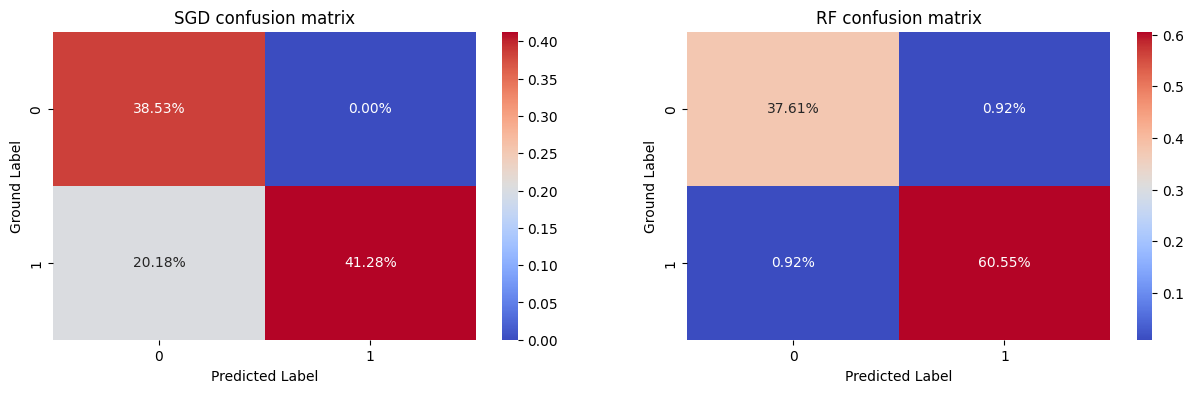

In [130]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(metadata_pointer, tp: str,ax):
    confusion_matrix = np.array(metadata_pointer["confusion_matrix"].value, dtype=float).reshape((2,2))
    confusion_matrix /= np.sum(confusion_matrix)
    sns.heatmap(confusion_matrix, annot=True,fmt='.2%',cmap="coolwarm",ax=ax)
    ax.set_title(f"{tp} confusion matrix")
    ax.set_ylabel("Ground Label")
    ax.set_xlabel("Predicted Label")

fig, ax = plt.subplots(1,2,figsize=(15,4))
plot_confusion_matrix(sgd_clf_metadata, "SGD",ax[0])
plot_confusion_matrix(rf_clf_metadata, "RF",ax[1])

So far we were able to collect all the information we tracked using Model Control Plane, but we also had Weights&Biases tracking enabled - let's dive into.

Thanks to Model Control Plane metadata we establish a nice connection between those 2 entities:

In [131]:
print(f'SGD version: {sgd_model_version.run_metadata["wandb_url"].value}')
print(f'RF version: {rf_model_version.run_metadata["wandb_url"].value}')

SGD version: https://wandb.ai/zenmlcode/zenml-projects-stack-showcase/runs/u36gintc
RF version: https://wandb.ai/zenmlcode/zenml-projects-stack-showcase/runs/71w79kyo
